# Notebook Setup

https://www.kaggle.com/keremt/pytorch-entity-embeddings was super helpful with this.

In [1]:
import os.path
import random
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skopt
import torch
import warnings

from pathlib import Path

In [2]:
sys.path.append(os.path.abspath('..'))

In [3]:
# Functions
from localhelpers import eim_train
from localhelpers import eim_validate
from localhelpers import emb_init
from localhelpers import get_embs_dims
from localhelpers import paired_ttest_5x2cv
from localhelpers import plot_pr_curve
from localhelpers import preprocess
from localhelpers import seed_everything
from localhelpers import threshold_array

# Classes
from localhelpers import BaselineEstimator
from localhelpers import CheckpointSaver
from localhelpers import CustomEstimator
from localhelpers import EimDataPreprocess
from localhelpers import EimDataset
from localhelpers import EimModel
from localhelpers import EimModelData
from localhelpers import ProgressCallback

Generate plots in notebook and suppress warnings

In [4]:
%matplotlib inline
warnings.filterwarnings('ignore')

Seed random number generators for reproducibility.

In [5]:
random_seed = int(time.time())
print(f'Using random seed {random_seed}')
seed_everything(random_seed)

Using random seed 1552868536


# Data processing

In [6]:
eim_csv = Path('../../fastai/combine-hallelujah-dust-new-split-no-nrs/data/good_reaction_trials_categorified_q90_javier_all_no_nrs.csv')

eim_df = pd.read_csv(eim_csv)
train_df = eim_df[eim_df.song == 'into_dust'].copy()
valid_test_df = eim_df[eim_df.song == 'hallelujah'].copy()

del eim_df

# train_df = train_df.iloc[0:128]
train_df.head()

,_id,location,language,nationality,age,sex,hearing_impairments,personality_trusting,personality_artistic,personality_imagination,...,musicpref_world,musicpref_dance,musicpref_rock,musicpref_jazz,musicpref_hip_hop,musicpref_none,musicpref_classical,musicpref_hiphop,musicpref_pop,musicpref_folk
0,570eb7aa83a73509d0e0489f,taipei_city,en,taiwanese,34.0,female,0,5,1,4,...,0,0,0,0,0,0,1,0,1,0
1,570eb75c83a73509d0e03009,taipei_city,en,taiwanese,7.0,male,0,5,4,5,...,0,0,0,0,0,0,0,0,0,1
2,570eb79983a73509d0e04371,taipei_city,zh_TW,taiwanese,12.0,female,0,4,3,5,...,0,0,0,0,0,0,0,0,1,0
3,570eb7a183a73509d0e045d2,taipei_city,en,taiwanese,7.0,male,0,4,3,4,...,0,0,0,0,0,0,1,0,0,0
4,570eb78a83a73509d0e03e96,taipei_city,zh_TW,thai,9.0,male,0,4,1,5,...,0,0,0,0,0,0,0,0,1,0


In [7]:
cats = ['location', 'sex', 'musical_background', 'nationality', 'visual_impairments', 'hearing_impairments', 
        'musicpref_traditional_irish', 'musicpref_jazz', 'musicpref_folk', 'musicpref_hiphop', 'musicpref_classical', 
        'musicpref_none', 'musicpref_rock', 'musicpref_hip_hop', 'musicpref_world', 'musicpref_pop', 'musicpref_dance',
        'language']

conts = ['musical_expertise', 'age', 'control_activity', 'control_tension', 'control_engagement', 
         'control_positivity', 'control_like_dislike', 'song_chillsshiversthrills', 'song_activity', 'song_tension', 
         'song_familiarity', 'song_engagement', 'song_positivity', 'song_like_dislike', 'song_inspired', 'song_wonder', 
         'song_spirituality', 'song_thrills', 'song_chills', 'song_tenderness', 'song_nostalgia', 'song_goosebumps', 
         'song_overwhelmed', 'song_shivers', 'control_power', 'song_transcendence', 'song_sadness', 'song_joyfulactivation', 
         'song_peacefulness', 'song_power', 'personality_trusting', 'personality_artistic', 'personality_imagination', 
         'personality_reserved', 'personality_outgoing', 'personality_lazy', 'personality_stress', 'personality_nervous', 
         'personality_fault', 'personality_thorough', 'concentration']

In [8]:
train_df.head()

,_id,location,language,nationality,age,sex,hearing_impairments,personality_trusting,personality_artistic,personality_imagination,...,musicpref_world,musicpref_dance,musicpref_rock,musicpref_jazz,musicpref_hip_hop,musicpref_none,musicpref_classical,musicpref_hiphop,musicpref_pop,musicpref_folk
0,570eb7aa83a73509d0e0489f,taipei_city,en,taiwanese,34.0,female,0,5,1,4,...,0,0,0,0,0,0,1,0,1,0
1,570eb75c83a73509d0e03009,taipei_city,en,taiwanese,7.0,male,0,5,4,5,...,0,0,0,0,0,0,0,0,0,1
2,570eb79983a73509d0e04371,taipei_city,zh_TW,taiwanese,12.0,female,0,4,3,5,...,0,0,0,0,0,0,0,0,1,0
3,570eb7a183a73509d0e045d2,taipei_city,en,taiwanese,7.0,male,0,4,3,4,...,0,0,0,0,0,0,1,0,0,0
4,570eb78a83a73509d0e03e96,taipei_city,zh_TW,thai,9.0,male,0,4,1,5,...,0,0,0,0,0,0,0,0,1,0


In [9]:
train_valid_test_df = pd.concat([train_df, valid_test_df],0)

# Remove id, name, and item_description columns
train_test_df = train_valid_test_df.drop(['_id'], axis=1)

In [10]:
train_valid_test_df.loc[train_valid_test_df.critical_reaction == False, 'critical_reaction'] = 0
train_valid_test_df.loc[train_valid_test_df.critical_reaction == True, 'critical_reaction'] = 1

In [11]:
# Replace missing values and convert brand_name and category_name to categories
train_valid_test_df = preprocess(train_valid_test_df, cats)

In [12]:
train_valid_test_df = train_valid_test_df.reset_index(drop=True)

In [13]:
# Convert values in categorical columns to 0, 1, 2, 3, ... from the top of the DataFrame down
train_valid_test_df = EimDataPreprocess(train_valid_test_df, cats, inplace=True)

In [14]:
# Split combined DataFrame back out into train and test DataFrames
train_df = train_valid_test_df.iloc[range(len(train_df))]
valid_test_df = train_valid_test_df.iloc[range(len(train_df),len(train_valid_test_df))]

In [15]:
valid_pct, test_pct = .8, .2
idxs = valid_test_df.index.values.copy()
np.random.shuffle(idxs)
split = int(np.floor(valid_pct * len(valid_test_df)))
valid_idxs, test_idxs = idxs[:split], idxs[split:]

In [16]:
# train_valid_df = train_df.copy()
valid_df = valid_test_df.loc[valid_idxs, :]
test_df = valid_test_df.loc[test_idxs, :]

In [17]:
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [18]:
train_df.head()

,_id,location,language,nationality,age,sex,hearing_impairments,personality_trusting,personality_artistic,personality_imagination,...,musicpref_world,musicpref_dance,musicpref_rock,musicpref_jazz,musicpref_hip_hop,musicpref_none,musicpref_classical,musicpref_hiphop,musicpref_pop,musicpref_folk
0,570eb7aa83a73509d0e0489f,0,0,0,34.0,0,0,5,1,4,...,0,0,0,0,0,0,0,0,0,0
1,570eb75c83a73509d0e03009,0,0,0,7.0,1,0,5,4,5,...,0,0,0,0,0,0,1,0,1,1
2,570eb79983a73509d0e04371,0,1,0,12.0,0,0,4,3,5,...,0,0,0,0,0,0,1,0,0,0
3,570eb7a183a73509d0e045d2,0,0,0,7.0,1,0,4,3,4,...,0,0,0,0,0,0,0,0,1,0
4,570eb78a83a73509d0e03e96,0,1,1,9.0,1,0,4,1,5,...,0,0,0,0,0,0,1,0,0,0


In [19]:
# Segment train and test DataFrames into input and output DataFrames
train_input, train_y = train_df.drop('critical_reaction', 1), train_df.critical_reaction
valid_input, valid_y = valid_df.drop('critical_reaction', 1), valid_df.critical_reaction
test_input, test_y = test_df.drop('critical_reaction', 1), test_df.critical_reaction

In [20]:
# Determine the range of output values
y_range = (train_y.min(), train_y.max())
y_range

(0, 1)

In [21]:
# Get a list of tuples of embedding dimensions
# Tuples are (category_size, embedding_size), where embedding_size is the smaller of 50 and half the number of unique values in that category
emb_szs = get_embs_dims(train_test_df, cats)
emb_szs

[(3, 3),
 (2, 2),
 (2, 2),
 (6, 4),
 (1, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (3, 3)]

# Initial model construction

In [22]:
model_data = EimModelData.from_data_frames('./tmp', train_input, valid_input, train_y, valid_y, 
                                           cats, conts, bs=len(train_input), test_df=test_df)
emb_model = EimModel(emb_szs, len(conts), 0.04, 1, [1000, 500], 0.01, y_range=y_range, classify=True, use_bn=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
emb_model.to(device)
emb_model

EimModel(
  (embs): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(2, 2)
    (2): Embedding(2, 2)
    (3): Embedding(6, 4)
    (4): Embedding(1, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(2, 2)
    (10): Embedding(2, 2)
    (11): Embedding(2, 2)
    (12): Embedding(2, 2)
    (13): Embedding(2, 2)
    (14): Embedding(2, 2)
    (15): Embedding(2, 2)
    (16): Embedding(2, 2)
    (17): Embedding(3, 3)
  )
  (lins): ModuleList(
    (0): Linear(in_features=81, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.01)
    (1): D

In [23]:
model_data_test = EimModelData.from_data_frames('./tmp', train_input, valid_input, train_y, valid_y, cats, conts, bs=len(train_input))

# Hyperparameter optimization

In [24]:
from skopt.space import Real, Integer, Categorical

param_order = [
    'learning_rate',
    'weight_decay',
    'layers',
    'dropouts',
    'embedding_dropout'
]

dimensions = [
    Real(1e-8, 0.5, name='learning_rate'),
    Real(1e-5, 1e-1, name='weight_decay'),
    Categorical([(60, 60), (60, 30), (60, 30, 15), (30, 15)], name='layers'),
    Real(0., 0.75, name='dropouts'),
    Real(0., 0.75, name='embedding_dropout')
]

@skopt.utils.use_named_args(dimensions=dimensions)
def objective(learning_rate=1e-4, weight_decay=0.04, epochs=10, layers=[10, 10], dropouts=[0.2, 0.2], 
              embedding_dropout=0.2, use_batch_norm=True):
    
    # Reset as much as possible
    torch.cuda.empty_cache()
    seed_everything(random_seed)

    layers = list(layers)
    
    # Build model
    emb_model = EimModel(emb_szs, len(conts), embedding_dropout, 1, layers, dropouts, y_range=y_range, 
                         classify=True, use_bn=use_batch_norm)
    emb_model.to(device)
    
    opt = torch.optim.SGD(emb_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    crit = torch.nn.functional.binary_cross_entropy
    losses = eim_train(emb_model, model_data, opt, crit, epochs, patience=25, print_output=False, save_best=False)
    
    return(min(losses['validation']))

In [31]:
import pathlib

opt_checkpoint_path = Path('.', 'opt_checkpoint.pkl')

resume_optimization = True
previous_x0, previous_y0 = None, None
n_calls, n_called = 250, 0

if resume_optimization:
    from skopt import load
    
    if opt_checkpoint_path.exists():
        previous_res = load(opt_checkpoint_path)
        previous_x0 = previous_res.x_iters
        previous_y0 = previous_res.func_vals
        n_called = len(previous_x0)

In [32]:
n_called

0

In [33]:
n_calls - n_called

10

In [34]:
checkpoint_callback = CheckpointSaver(opt_checkpoint_path)
progress_callback = ProgressCallback(n_calls)

In [35]:
opt_results = skopt.gp_minimize(objective,
                                dimensions,
                                n_calls=n_calls - n_called,
                                random_state=random_seed,
                                x0=previous_x0,
                                y0=previous_y0,
                                callback=[progress_callback, checkpoint_callback])

Completed optimization trial 1/10. Best loss so far: 0.690820
Completed optimization trial 2/10. Best loss so far: 0.690820
Completed optimization trial 3/10. Best loss so far: 0.673941
Completed optimization trial 4/10. Best loss so far: 0.673941
Completed optimization trial 5/10. Best loss so far: 0.673941
Completed optimization trial 6/10. Best loss so far: 0.673941
Completed optimization trial 7/10. Best loss so far: 0.664512
Completed optimization trial 8/10. Best loss so far: 0.664512
Completed optimization trial 9/10. Best loss so far: 0.664512
Completed optimization trial 10/10. Best loss so far: 0.664512


## Save hyperparameter optimization results

In [36]:
from skopt import dump
dump(opt_results, opt_checkpoint_path)

# Train tuned model

## Get best parameters

In [37]:
from skopt import load
opt_results = load(opt_checkpoint_path)

In [38]:
print('Best loss: {}'.format(opt_results.fun))

Best loss: 0.6645122170448303


In [39]:
print('Parameters:')
opt_params = dict(zip(param_order, opt_results.x))
opt_params

Parameters:


{'learning_rate': 0.40983857519928474,
 'weight_decay': 0.03486126899435303,
 'layers': (60, 60),
 'dropouts': 0.5528824875538156,
 'embedding_dropout': 0.175144466631944}

Train model with these parameters until we start to diverge

In [40]:
opt = torch.optim.SGD(emb_model.parameters(), lr = 1e-2, weight_decay=1e-4)
crit = torch.nn.functional.binary_cross_entropy

seed_everything(random_seed)
epochs = 5000
emb_model = EimModel(emb_szs, len(conts), opt_params['embedding_dropout'], 1, list(opt_params['layers']), 
                     opt_params['dropouts'], y_range=y_range, classify=True, 
                     use_bn=True)
emb_model.to(device)
opt = torch.optim.SGD(emb_model.parameters(), lr=opt_params['learning_rate'], weight_decay=opt_params['weight_decay'])
losses = eim_train(emb_model, model_data, opt, crit, epochs, save_best=True, print_output=False)

## Plot training results

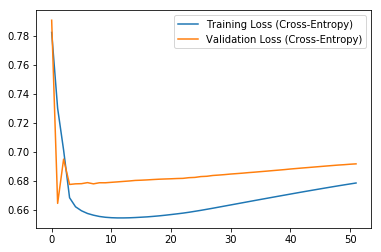

In [41]:
plt.plot(losses['train'], label='Training Loss (Cross-Entropy)')
plt.plot(losses['validation'], label='Validation Loss (Cross-Entropy)')
plt.legend();

## Load best model

In [42]:
emb_model = EimModel(emb_szs, len(conts), opt_params['embedding_dropout'], 1, list(opt_params['layers']), 
                     opt_params['dropouts'], y_range=y_range, classify=True, 
                     use_bn=True)
emb_model.to(device)
emb_model.load_state_dict(torch.load(Path('.', 'best_model.pkl')))

## Evaluate validation set against model

In [43]:
data = next(iter(model_data.val_dl))

emb_model.eval()

# get inputs
x_cats, x_conts, y = data

# wrap with variable
x_cats = torch.LongTensor(x_cats).to(device)
x_conts = torch.FloatTensor(x_conts).to(device)
y = torch.FloatTensor(y).to(device)
x_cats.requires_grad = False
x_conts.requires_grad = False
y.requires_grad = False

val_outputs = emb_model(x_cats, x_conts).cpu().detach().numpy()
val_y = y.cpu().detach().numpy()

### Plot validation AUC-PR

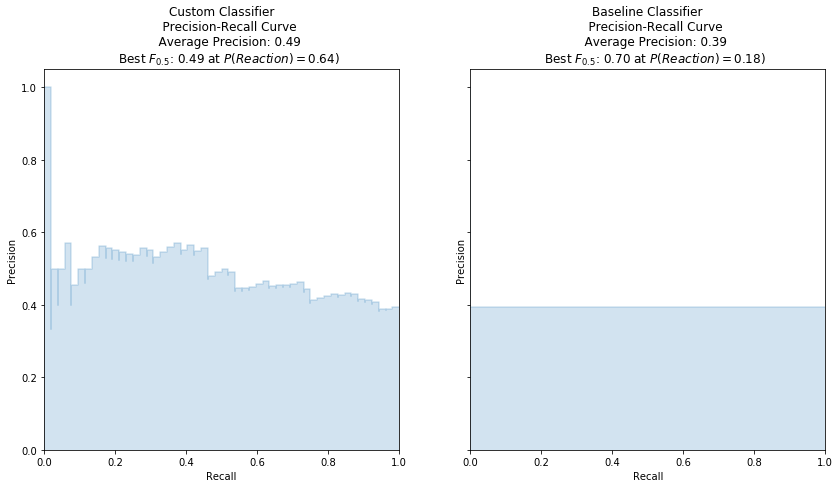

In [44]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14, 7))

plt.sca(ax[0])
plot_pr_curve(val_y, val_outputs, 'Custom Classifier')

plt.sca(ax[1])
plot_pr_curve(val_y, np.zeros(len(val_outputs)), 'Baseline Classifier')

## Evaluate test set against model

In [45]:
test_outputs = None
for data in iter(model_data.test_dl):

    emb_model.eval()

    # get inputs
    x_cats, x_conts, y = data

    # wrap with variable
    x_cats = torch.LongTensor(x_cats).to(device)
    x_conts = torch.FloatTensor(x_conts).to(device)
    x_cats.requires_grad = False
    x_conts.requires_grad = False

    outputs = emb_model(x_cats, x_conts).cpu().detach().numpy()
    if test_outputs is not None:
        test_outputs = np.concatenate((test_outputs, outputs))
    else:
        test_outputs = outputs

### Plot test AUC-PR

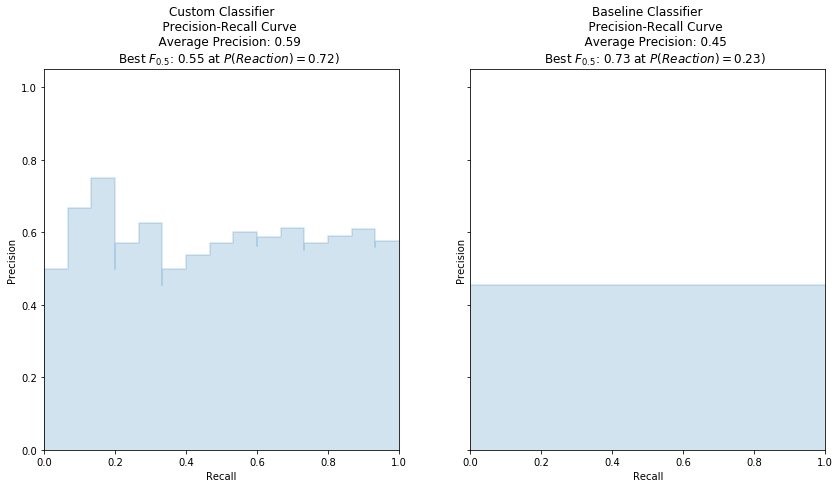

In [46]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14, 7))

plt.sca(ax[0])
plot_pr_curve(test_y, test_outputs, 'Custom Classifier')

plt.sca(ax[1])
plot_pr_curve(test_y, np.zeros(len(test_outputs)), 'Baseline Classifier')